In [1]:
import cv2
import numpy as np
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from sklearn.cluster import KMeans
from tqdm import tqdm

Question 1 Filters

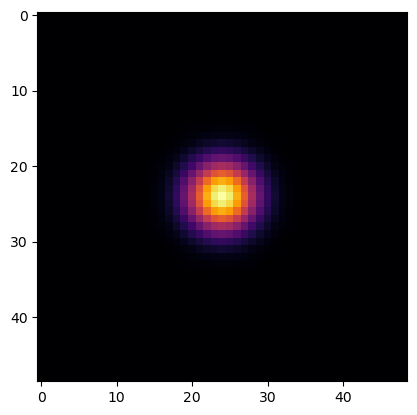

In [2]:
def GaussFilter(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    g = (1/(2*np.pi * sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    #normalisng it - sometimes the sum is not perfectly 1...
    g /= np.sum(g)
    # print(np.sum(g))
    return g

test_gauss = GaussFilter(49, 10**0.5)
plt.imshow(test_gauss, cmap="inferno")

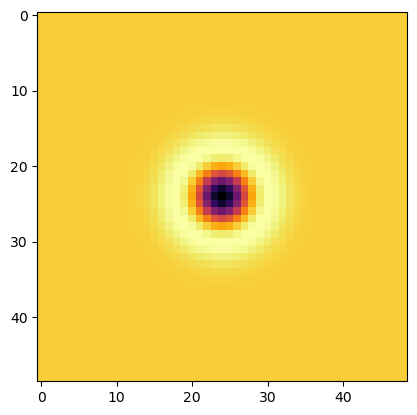

In [3]:
def LoG(size, sigma):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = -((1)/(np.pi * sigma ** 4 )) * \
        (1- (x**2 + y**2)/(2* sigma **2)) * \
        np.exp(-(x**2 + y**2)/(2*sigma**2))
    

    return g
test_log = LoG(49, 10**0.5)
plt.imshow(test_log,cmap="inferno")

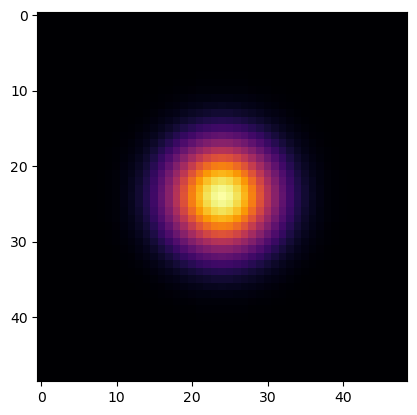

In [4]:
def DoG(size, sigma, K):
    values =np.arange(-(size//2), size//2 + 1)
    x, y = np.meshgrid(values, values)
    
    g = (1/(2 * np.pi * sigma **2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * sigma **2)) - \
        (1/ (2 * np.pi * K**2 *sigma**2)) * \
        np.exp(-(x**2 + y ** 2)/(2 * K**2 * sigma **2))

    return g 
    
test_dog = DoG(49, 5, 10)
plt.imshow(test_dog,cmap="inferno")

Question 3

In [5]:
def getLBPs(img,show_plot=False):
    lbps = []
    radii = [4, 8, 16, 24, 32]
    for radius in radii:
        lbp = skimage.feature.local_binary_pattern(img,12,radius,'uniform')
        lbps.append(lbp)

    if show_plot:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i, (img, label) in enumerate(zip(lbps, radii)):
            axes[i].imshow(img, cmap="gray")
            axes[i].axis('off')
            axes[i].set_title(label)  

        plt.tight_layout()
        plt.show()

    return np.array(lbps)

In [6]:
def apply_haar_filter(integral_images, filter_size,show_plot=False):
    h, w = integral_images[0].shape
    # integral images have a buffer at the end of each axis
    h= h-1
    w= w-1
    response = np.zeros((len(integral_images),h,w))
    
    for i in range(len(integral_images)):  # For each channel (R, G, B)
        integral_image = integral_images[i]
        
        for y in range(h):
            for x in range(w):
                A = integral_image[max(0,y - filter_size//2),max(0,x - filter_size//2)]
                B = integral_image[max(0,y - filter_size//2),min(w,x + filter_size//2)]
                C = integral_image[min(h,y + filter_size//2),max(0,x - filter_size//2)]
                D = integral_image[min(h,y + filter_size//2), min(w,x + filter_size//2)]
                
                pos_sum = A + D
                
                neg_sum = B + C
                
                response[i,y,x] = pos_sum - neg_sum

    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i  in range(response.shape[0]):
            axes[i].imshow(response[i].astype(np.uint8), )
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
                
    return response

Section 4

In [7]:
from scipy.stats import multivariate_normal
from sklearn.preprocessing import OneHotEncoder

class Stat_Classifier:

    def __init__(self,image) -> None:
        self.image = image
        self.kmeans = None
        pass

    def classify(self, validation_features, fg_features, bg_features, train_mask, train_image):
        # Compute the means and covariances for foreground and background
        fg_feature_matrix = np.stack(fg_features, axis=-1)
        fg_mean_vector = np.mean(fg_feature_matrix, axis=0)
        fg_cov_matrix = np.cov(fg_feature_matrix, rowvar=False)

        bg_feature_matrix = np.stack(bg_features, axis=-1)
        bg_mean_vector = np.mean(bg_feature_matrix, axis=0)
        bg_cov_matrix = np.cov(bg_feature_matrix, rowvar=False)

        print("Features extracted from original")

        # Reshape the validation features for pixel-wise processing
        reshaped_features = validation_features.T
        print("Reshaped the test features")

       
        probabilities = self.foreground_given_pixel(reshaped_features, fg_mean_vector, fg_cov_matrix, 
                                                        bg_mean_vector, bg_cov_matrix,mask,image)
        print("Computed the feature array probabilities")
        return probabilities.reshape((450,600))


    
    def foreground_given_pixel(self,x,fg_mean, fg_cov, bg_mean, bg_cov,mask,image):
        """
        Args:
            mask (2d array): Remember to binarize it.
            image (type):the original image.

        Returns:
            type: probability.
        """
        N = image.shape[0]*image.shape[1]
        N_fg = np.sum(mask)
        N_bg = N - N_fg
        
        numerator = multivariate_normal.pdf( x, mean = fg_mean, cov= fg_cov, allow_singular=True) * (N_fg)
        denominator = multivariate_normal.pdf(x, mean=fg_mean, cov=fg_cov, allow_singular=True)*N_fg \
                    + multivariate_normal.pdf( x, mean= bg_mean, cov= bg_cov, allow_singular=True) * (N_bg)
        small_value = 1e-10  # You can adjust the small value if needed
        denominator = np.where(denominator == 0, small_value, denominator)
        probability = numerator/denominator
        return probability
    
    def getFeatures(self,training_img, mask, show_plot=False,MR8:bool = False, texton:bool = False):
        """
        Parameters:
            training_img (2d array): training image.
            mask (type): binarized image.

        Returns:
            type: Flattened features.
        """
        if(type(mask[0][0]) != np.bool_):
            binary_mask = mask >128

        vertical_prewitt = np.array([
            [1,1,1],
            [0,0,0],
            [-1,-1,-1]
        ])
        horizontal_prewitt = np.array([
            [1,0,-1],
            [1,0,-1],
            [1,0,-1]
        ])

        laplacian = np.array([
            [0,-1,0],
            [-1,4,-1],
            [0,-1,0]
        ])

        gauss = GaussFilter(49, 10**0.5)
        lgauss =  LoG(49, 10**0.5)
        dgauss = DoG(49,5,10)

        binary_mask = mask>128
        #plt.imshow(binary_mask)
        
        #add dimensions
        # print(binary_mask.shape)
        hsv_training_img = cv2.cvtColor(training_img, cv2.COLOR_BGR2RGB)
        v,s,h = cv2.split(hsv_training_img)
        h, s,v = h*binary_mask, s*binary_mask, v*binary_mask
        # print(h.shape)
        b,g,r = cv2.split(training_img)
        r,g,b = r*binary_mask, g*binary_mask, b*binary_mask


        # get vertical prewitt for separated channels

        vert_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=vertical_prewitt)
        vert_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=vertical_prewitt)
        # get horizontal prewitt for separated channels

        hori_prewitt_r = cv2.filter2D(src=r, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_g = cv2.filter2D(src=g, ddepth=-1, kernel=horizontal_prewitt)
        hori_prewitt_b = cv2.filter2D(src=b, ddepth=-1, kernel=horizontal_prewitt)
        # get Laplacian for separated channels

        laplace_r = cv2.filter2D(src=r, ddepth=-1, kernel=laplacian)
        laplace_g = cv2.filter2D(src=g, ddepth=-1, kernel=laplacian)
        laplace_b = cv2.filter2D(src=b, ddepth=-1, kernel=laplacian)

        # get gaussian for seperate channels
        gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = gauss)
        gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = gauss)
        gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = gauss)

        # get log of gaussian for seperate channels
        l_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = lgauss)
        l_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = lgauss)
        l_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = lgauss)

        # get log of gaussian for seperate channels
        d_gauss_r = cv2.filter2D(src=r, ddepth=-1, kernel = dgauss)
        d_gauss_g = cv2.filter2D(src=g, ddepth=-1, kernel = dgauss)
        d_gauss_b = cv2.filter2D(src=b, ddepth=-1, kernel = dgauss)

        # get LBPs for seperate channels
        lbp_r = getLBPs(r)
        lbp_g = getLBPs(g)
        lbp_b = getLBPs(b)

        # get Harr for seperate channels and sizes
        integral_images = [cv2.integral(training_img[:,:,i]) for i in range(3)]
        haar4 = apply_haar_filter(integral_images,4)
        haar8 = apply_haar_filter(integral_images,8)
        haar16 = apply_haar_filter(integral_images,16)

        if show_plot:
            # vertical prewitt plot 
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( vert_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( vert_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( vert_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Vertical Prewitt of RGB image")
            plt.show()

            # horizontal prewitt plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( hori_prewitt_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( hori_prewitt_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( hori_prewitt_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Horizontal Prewitt of RGB image")
            plt.show()

            # laplace plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( laplace_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( laplace_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( laplace_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Laplacian of RGB image")
            plt.show()

            # gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Gaussian of RGB image")
            plt.show()


            # log of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( l_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( l_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( l_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Log of Gaussian of RGB image")
            plt.show()

            # difference of gaussian plot
            fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(16,4))
            plt.subplot(1,3,1), plt.imshow( d_gauss_r,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,2), plt.imshow( d_gauss_g,cmap="gray"), plt.axis("off")
            plt.subplot(1,3,3), plt.imshow( d_gauss_b,cmap="gray"), plt.axis("off")
            plt.suptitle("Difference of Gaussian of RGB image")
            plt.show()

            # LBP Red plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_r, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Red image")
            plt.show()

            # LBP Green plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_g, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Green image")
            plt.show()

            # LBP Blue plot
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))
            for i, (img, label) in enumerate(zip(lbp_b, [4,8,16,24,32])):
                axes[i].imshow(img, cmap="gray")
                axes[i].axis('off')
                axes[i].set_title(label)  

            plt.suptitle("LBPs of Blue image")
            plt.show()

            # Haar4 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar4.shape[0]):
                axes[i].imshow(haar4[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 4 of RGB image")
            plt.show()

            # Haar8 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar8.shape[0]):
                axes[i].imshow(haar8[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 8 of RGB image")
            plt.show()

            # Haar16 Filter plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i  in range(haar16.shape[0]):
                axes[i].imshow(haar16[i].astype(np.uint8),cmap="gray")
                axes[i].axis('off')

            plt.suptitle("Haar 16 of RGB image")
            plt.show()


        features = [
            vert_prewitt_r, hori_prewitt_r, 
            vert_prewitt_g, hori_prewitt_g, 
            vert_prewitt_b, hori_prewitt_b, 
            laplace_r, laplace_g, laplace_b,
            gauss_r, l_gauss_r, d_gauss_r,
            gauss_g, l_gauss_g, d_gauss_g,
            gauss_b, l_gauss_b, d_gauss_b,
            lbp_r[0],lbp_r[1],lbp_r[2],lbp_r[3],lbp_r[4],
            lbp_g[0],lbp_g[1],lbp_g[2],lbp_g[3],lbp_g[4],
            lbp_b[0],lbp_b[1],lbp_b[2],lbp_b[3],lbp_b[4],
            haar4[0],haar4[1],haar4[1],
            haar8[0],haar8[1],haar8[1],
            haar16[0],haar16[1],haar16[1],
            r, g, b,
            h, s, v,
        ]

        flattened_features = np.array([f[binary_mask].flatten() for f in features]) 
        print("Shape of flattened_features before texton:", flattened_features.shape)


        if texton:
            # Extract textons
            textons = self.textons(image, mask)
            
            # One-hot encode the textons
            encoder = OneHotEncoder(categories=[range(4)], sparse_output=False)
            textons_one_hot = encoder.fit_transform(textons.flatten().reshape(-1, 1))
            
            # # Flatten the mask to get valid indices
            # mask_flattened = mask.flatten()
            
            # # Ensure the mask is applied correctly
            # valid_indices = mask_flattened == 255
            
            # # Filter textons using the mask
            # # We need to ensure the valid_indices match the dimension of textons_one_hot
            # if len(valid_indices) == textons_one_hot.shape[0]:
            #     filtered_textons = textons_one_hot[valid_indices]
            # else:
            #     raise ValueError("Dimension mismatch between valid_indices and textons_one_hot")

            # Transpose filtered_textons to get the shape (4, number of valid pixels)
            filtered_textons = textons_one_hot.T  # Shape: (4, number of valid pixels)
            
            print("Shape of filtered_textons:", filtered_textons.shape)
            
            # Concatenate along the features axis (features should be appended)
            concatenated_features = np.concatenate([flattened_features, filtered_textons], axis=0)
            
            print("Shape of concatenated_features:", concatenated_features.shape)
        
        return flattened_features


        return np.array(flattened_features)
    
    def textons(self, image, mask, plot=False):
        original_features = self.getFeatures(image, mask, False)
        print(original_features.shape)
        
        perpixel_features = np.swapaxes(original_features, 0, 1)
        print("Clustering!")
        
        # mask_flattened = mask.flatten()
        # masked_features = perpixel_features[mask_flattened]
        
        kmeans = KMeans(n_clusters=4, random_state=42).fit(perpixel_features)
        textons_intern = kmeans.labels_
        
             
        if plot:
            plt.imshow(textons_intern.reshape(mask.shape))
            plt.show()
        
        return textons_intern

    def dummy_test(self, image_path):
        # Mask,inverse and image (original in the lab1)

        # Example usage within the dummy_test or other testing functions:
        image = cv2.imread("Images/image-35.jpg")
        mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
        inverse_mask = 255 - mask 
        class_inst = Stat_Classifier(image)

        # Extract textons from the training image
        # train_textons = class_inst.textons(image, )

        # Validation features
        null = np.ones_like(mask) * 255
        validation_img = cv2.imread("Images/image-83.jpg")

        validation_features = class_inst.getFeatures(validation_img, null, show_plot=False, texton=True)
        fg_features = class_inst.getFeatures(image, mask, show_plot=False, texton=True)
        bg_features = class_inst.getFeatures(image, inverse_mask, show_plot=False, texton=True)

        # Extract textons for the validation image
        # validation_textons = class_inst.textons(validation_img, null)

        # Classify 
        verify_img = class_inst.classify(validation_features, fg_features, bg_features, mask, image)
        theta = 0.5
        thresholded_img = verify_img.copy() > theta
        plt.figure()
        plt.imshow(thresholded_img, cmap="gray"), plt.title("Validation image prediction")
        plt.show()
        return verify_img
        # accuracy


    


### 4.2 Find and display Textons


Shape of flattened_features before texton: (48, 270000)
(48, 270000)


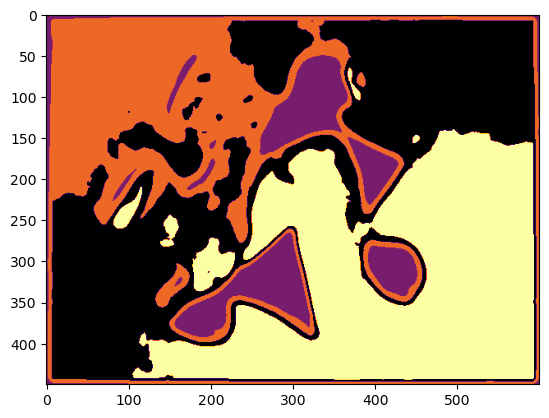

In [8]:

image = cv2.imread("Images/image-35.jpg")
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
classify_inst = Stat_Classifier(image)
null = np.ones_like(mask)*255
original_features = classify_inst.getFeatures(image,null,False)
print(original_features.shape)

perpixel_features = np.swapaxes(original_features,0,1)

kmeans = KMeans(n_clusters=4, random_state=42).fit(perpixel_features)
textons = kmeans.labels_
plt.imshow(textons.reshape(450,600), cmap="inferno")

### 4.3 Testing model accuracy on test Image

(450, 600, 3)
classifying the test image
Shape of flattened_features before texton: (48, 270000)
Shape of flattened_features before texton: (48, 270000)
(48, 270000)
Clustering!
Shape of filtered_textons: (4, 270000)
Shape of concatenated_features: (52, 270000)
Shape of flattened_features before texton: (48, 74571)
Shape of flattened_features before texton: (48, 74571)
(48, 74571)
Clustering!
Shape of filtered_textons: (4, 74571)
Shape of concatenated_features: (52, 74571)
Shape of flattened_features before texton: (48, 195424)
Shape of flattened_features before texton: (48, 195424)
(48, 195424)
Clustering!
Shape of filtered_textons: (4, 195424)
Shape of concatenated_features: (52, 195424)
Features extracted from original
Reshaped the test features
Computed the feature array probabilities


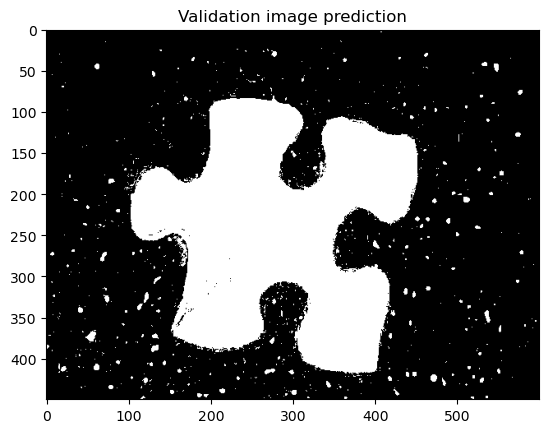

In [9]:
test_image = cv2.imread("Images/image-83.jpg")
image = cv2.imread("Images/image-35.jpg")
print(test_image.shape)
mask = cv2.imread("Images/mask-35.png", cv2.IMREAD_GRAYSCALE)
null = np.ones_like(mask)*255

classify_inst = Stat_Classifier(image)

print("classifying the test image")
test_img_result = classify_inst.dummy_test("Images/image-83.jpg")


#### Accuracy using textons

In [10]:
from sklearn.metrics import confusion_matrix
test_mask = cv2.imread("Images/mask-83.png", cv2.IMREAD_GRAYSCALE)
def get_IOU_PosNeg(img1,img2):
    conf_matrix = confusion_matrix((img1 >0.99).astype(int).flatten(), (img2 >0.99).astype(int).flatten())
    TN = conf_matrix[0][0]
    fn = conf_matrix[1][0]
    tp = conf_matrix[1][1]
    fp = conf_matrix[0][1]
    iou = tp / (tp + fp + fn)

    return iou
print(get_IOU_PosNeg(test_mask, test_img_result))

0.8397654363573646
